## **MODEL TESTING**

In [1]:
import glob
import os
import warnings

import audioread
import ffmpeg
import librosa
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import Audio
from pydub import AudioSegment
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [2]:
class VocalSeparationBaseline(nn.Module):
    def __init__(self):
        super(VocalSeparationBaseline, self).__init__()
        # Convolutional layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # [B, 16, 128, 1292]
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # [B, 32, 128, 1292]
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),  # [B, 32, 64, 646]
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),  # [B, 16, 64, 646]
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),  # [B, 1, 64, 646]
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # [B, 1, 128, 1292]
        )
    
    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension [B, 1, 128, 1292]
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.squeeze(1)  # Remove channel dimension [B, 128, 1292]
    

In [3]:
#%% MODELO RNN
class VocalSeparationRNN(nn.Module):
    def __init__(self, input_size=128, hidden_size=256, num_layers=2, output_size=128, bidirectional=True):
        super(VocalSeparationRNN, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)

    def forward(self, x):
        x = x.transpose(1, 2)
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out)
        return output.transpose(1, 2)

In [4]:
class VocalSeparationHybrid(nn.Module):
    def __init__(self, n_mels=128, conv_filters=64, kernel_size=3, hidden_size=256, num_layers=2, output_size=128, bidirectional=True):
        super(VocalSeparationHybrid, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, conv_filters, kernel_size=(kernel_size, kernel_size), stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(conv_filters)
        self.conv2 = nn.Conv2d(conv_filters, conv_filters * 2, kernel_size=(kernel_size, kernel_size), stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(conv_filters * 2)
        
        # Update LSTM input_size dynamically based on conv_filters
        self.lstm_input_size = n_mels * (conv_filters * 2)  # Channels * n_mels
        
        # Recurrent layers
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )
        
        # Fully connected layer to map back to the original spectrogram dimensions
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)

    def forward(self, x):
        # x shape: [batch, channels, n_mels, time]
        x = x.unsqueeze(1)  # Add channel dimension for 2D convolutions
        
        # Convolutional layers
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        
        # Reshape for RNN: [batch, time, features]
        batch, channels, n_mels, time = x.shape
        x = x.permute(0, 3, 1, 2).reshape(batch, time, -1)  # Combine channels and n_mels
        
        # Check dimensions for debugging
        assert x.size(-1) == self.lstm_input_size, f"Expected LSTM input size {self.lstm_input_size}, got {x.size(-1)}"
        
        # Recurrent layers
        lstm_out, _ = self.lstm(x)
        
        # Fully connected layer
        output = self.fc(lstm_out)
        return output.transpose(1, 2)  # Reshape back to [batch, output_size, time]

In [5]:
#%% PRETRAINED MODEL ADAPTATION
from torchvision.models import resnet34

class VocalSeparationPretrained(nn.Module):
    def __init__(self):
        super(VocalSeparationPretrained, self).__init__()
        # Load a pretrained ResNet
        pretrained_resnet = resnet34(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(pretrained_resnet.children())[:-2])  # Remove final layers
        
        # Custom decoder for vocal separation
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),  # [B, 256, H/32, W/32]
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # [B, 256, H/16, W/16]
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),  # [B, 128, H/16, W/16]
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # [B, 128, H/8, W/8]
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),  # [B, 64, H/8, W/8]
            nn.ReLU(),
            nn.Upsample(scale_factor=8, mode='bilinear', align_corners=False),  # [B, 1, H, W]
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),  # Final vocal separation layer
            #nn.ReLU(),
        )
    
    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, 3, 1, 1)  # Convert grayscale to 3 channels [B, 3, H, W]
        features = self.feature_extractor(x)  # Extract features
        output = self.decoder(features)  # Decode to vocal separation
        return output.squeeze(1)  # Remove channel dimension [B, H, W]

/Users/pol/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/pol/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <008545DB-13C1-3E30-BD24-714C211461A0> /Users/pol/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <36F46DB8-DB62-3926-8653-E332C34252FB> /Users/pol/anaconda3/envs/torch/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
model = VocalSeparationBaseline()
#model = VocalSeparationRNN()
#model = VocalSeparationPretrained()
#model = VocalSeparationHybrid()

#model.load_state_dict(torch.load("cnn_model_100epochs_0.0001lr_L1.pth",  map_location=torch.device('cpu')))
#model.load_state_dict(torch.load("rnn_vocal_separation_model_100epochs_0.0001lr_L1.pth",  map_location=torch.device('cpu')))
#model.load_state_dict(torch.load("pretrained_model_50epochs_0.0001lr_L1_2.pth",  map_location=torch.device('cpu')))
#model.load_state_dict(torch.load("hybrid_model_50epochs_0.0001lr_L1.pth",  map_location=torch.device('cpu')))
#model.load_state_dict(torch.load("curriculum_model_100epochs_0.0001lr_L1.pth",  map_location=torch.device('cpu')))
model.load_state_dict(torch.load("KD_model_0.0001lr_100epochs.pth",  map_location=torch.device('cpu')))

/var/folders/z9/pq761jhd4zv939bx11btv4m00000gn/T/ipykernel_98667/1523065817.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_stude

<All keys matched successfully>

In [ ]:
#open the test file
test_audios = ["wild.mp3"]
test_example = retrieve_audio(test_audios, 0)
test_batch = collate_test(list(test_example))

Audio(data=get_audio(test_audios, 0), rate=22050)

In [101]:
model.eval()

with torch.no_grad():
    output = model(test_batch.unsqueeze(0))

# 1. Denormalize (if your spectrogram was normalized to [0, 1])
mel_spectrogram = output.detach().cpu().numpy()[0]  # Convert to numpy, use the first example in batch

min_db, max_db = -80.0, 0.0  # Original dB range
denormalized_mel = mel_spectrogram * (max_db - min_db) + min_db  # Reverse normalization

# 2. Convert back to the power spectrogram
power_spectrogram = librosa.db_to_power(denormalized_mel)

# 3. Invert the Mel spectrogram to waveform
# (You need the same sampling rate and Mel filterbank used during creation)
sr = 22050  # Replace with the actual sampling rate
y = librosa.feature.inverse.mel_to_audio(power_spectrogram, sr=sr, n_iter=128)
y_normalised = librosa.util.normalize(y)

Audio(data=y_normalised, rate=sr)

#import noisereduce as nr

# Apply noise reduction
#reduced_noise_audio = nr.reduce_noise(y=y_normalised, sr=sr)

#Audio(data=y_normalised, rate=sr)

In [17]:
# code to convert mp3 to 22050 sample rate

# open WILDFLOWER-Colors.mp3
audio = AudioSegment.from_file("wild_vocals.mp3")

# convert to 22050 sample rate
audio = audio.set_frame_rate(22050)

# save as WILDFLOWER-Colors.mp3
audio.export("wild_vocals.mp3", format="mp3")


<_io.BufferedRandom name='wild_vocals.mp3'>

In [18]:
# load the original vocals audio file
vocal_audios = ["wild_vocals.mp3"]
vocal_example = retrieve_audio(vocal_audios, 0)
vocal_batch = collate_test(list(vocal_example))

Audio(data=get_audio(vocal_audios, 0), rate=22050)

/Users/pol/anaconda3/envs/torch/lib/python3.9/site-packages/librosa/core/audio.py:172: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [ ]:
#get the spectrogram of original vocals
vocal_mel = librosa.feature.melspectrogram(y=get_audio(vocal_audios, 0), sr= 22050, n_mels= 128)
vocal_db = librosa.power_to_db(vocal_mel, ref=np.max)

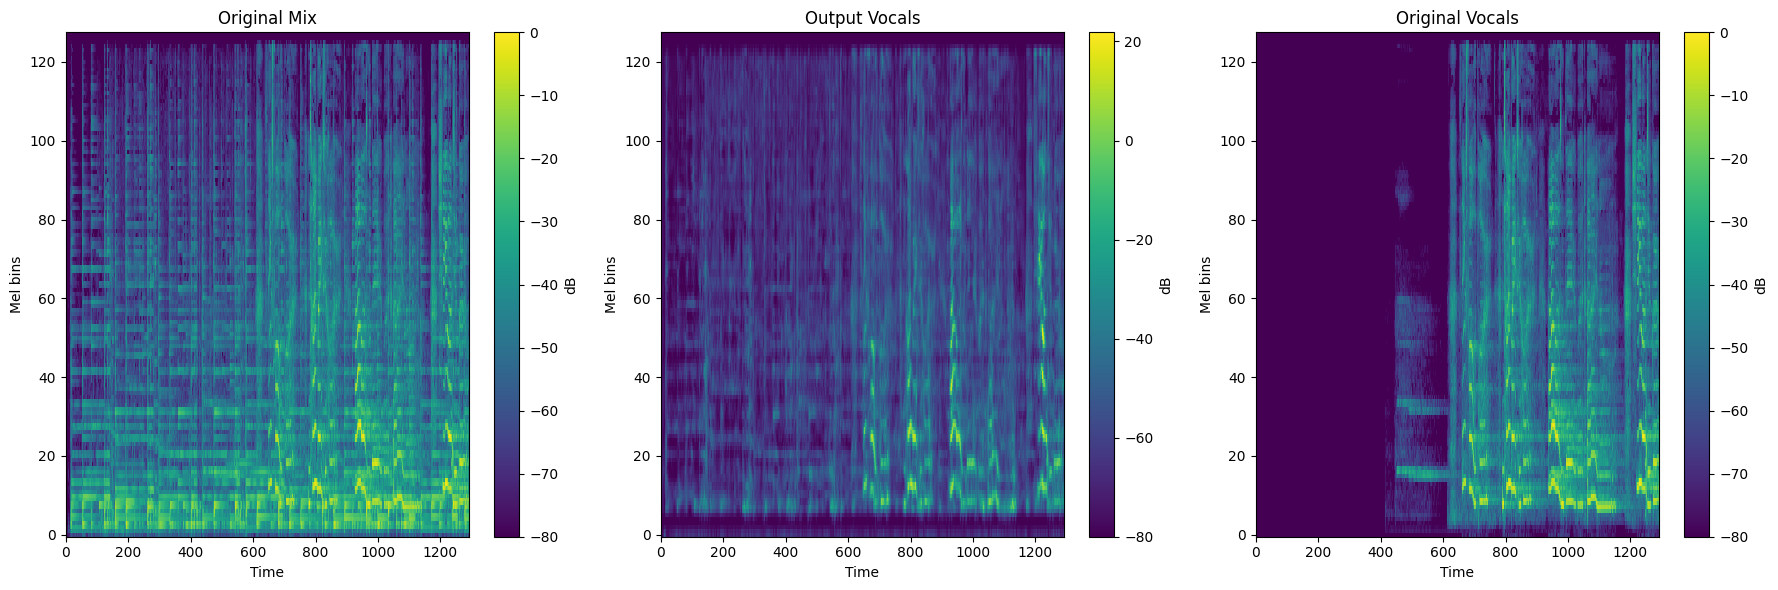

In [102]:
# Plot spectrograms
plt.figure(figsize=(18, 6))

# Original Mel spectrogram
plt.subplot(1, 3, 1)
plt.title("Original Mix")
plt.imshow(test_batch.numpy(), aspect='auto', origin='lower', interpolation='none')
plt.colorbar(label='dB')
plt.xlabel('Time')
plt.ylabel('Mel bins')

# Denormalized Mel spectrogram
plt.subplot(1, 3, 2)
plt.title("Output Vocals")
plt.imshow(denormalized_mel, aspect='auto', origin='lower', interpolation='none')
plt.colorbar(label='dB')
plt.xlabel('Time')
plt.ylabel('Mel bins')

# Vocal separation
plt.subplot(1, 3, 3)
plt.title("Original Vocals")
plt.imshow(vocal_db, aspect='auto', origin='lower', interpolation='none')
plt.colorbar(label='dB')
plt.xlabel('Time')
plt.ylabel('Mel bins')

plt.tight_layout()
plt.savefig("KD.png", transparent=True)

